In [1]:
#problem statement - The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. 
#So, the task is to classify racist or sexist tweets from other tweets.

#Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ 
#denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

#Note: The evaluation metric from this practice problem is F1-Score.

## Loading libraries and Data

In [1]:
import re    # for regular expressions
import nltk  # for text manipulation
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 


pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
train  = pd.read_csv('C:/Users/singh/Desktop/Twitter SA/train_E6oV3lV.csv')
test =   pd.read_csv('C:/Users/singh/Desktop/Twitter SA/test_tweets_anuFYb8.csv')

Text is a highly unstructured form of data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

### DATA INSPECTION

In [4]:
train[train['label']==0].head(5) #Let’s check out a few non racist/sexist tweets.


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [5]:
train[train['label']==1].head(5) #Let’s check out a few racist/sexist tweets.

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [6]:
#dimension
train.shape, test.shape

((31962, 3), (17197, 2))

In [7]:
#Let’s have a glimpse at label-distribution in the train dataset
train["label"].value_counts() #to get counts

0    29720
1     2242
Name: label, dtype: int64

In [8]:
#In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as 
#non racist/sexist. So, it is an imbalanced classification challenge.

In [9]:
#Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

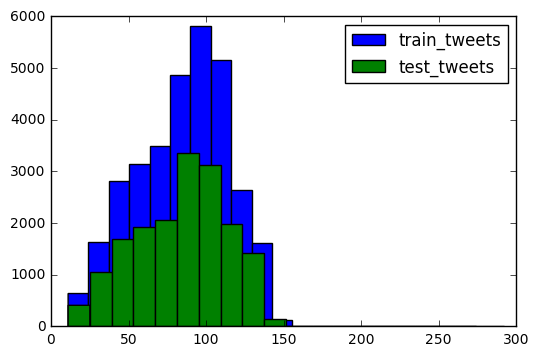

In [10]:
length_train = train['tweet'].str.len() #length of tweets
length_test =  test['tweet'].str.len()  #Length of tweets

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test,  bins=20, label="test_tweets")
plt.legend() #to show legends
plt.show()

In any natural language processing task, cleaning raw text data is an important step. 
It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, 
special characters, numbers, and terms which don’t carry much weightage in context to the text.

Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. 
Later we will split it back into train and test data.

In [11]:
combi = train.append(test, ignore_index=True) #using append function
combi.shape #combining the train and test dataset

(49159, 3)

In [12]:
#Given below is a user-defined function to remove unwanted text patterns from the tweets.
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

We will be following the steps below to clean the raw tweets in out data.

We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

1) Let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. 
Note that we have passed “@[]*” as the pattern to the remove_pattern function. 
It is actually a regular expression which will pick any word starting with ‘@’.



In [13]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*") 
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


2. Removing Punctuations, Numbers, and Special Characters

Here we will replace everything except characters and hashtags with spaces. 
The regular expression “[^a-zA-Z#]” means anything except alphabets and ‘#’.

In [14]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")



3. Removing Short Words

We have to be a little careful here in selecting the length of the words which we want to remove. 
So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. 
It is better to get rid of them.



In [15]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#lamda function works for "for All"

x="This is India"
x.split()
' '.join(x)

4. Text Normalization

Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a 
string of text into tokens.

In [16]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [17]:
#Now we can normalize the tokenized tweets.

from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [18]:
len(tokenized_tweet)

49159

In [19]:
#Now let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_tweet'] = tokenized_tweet

In [20]:
combi['tidy_tweet']

0                                                          when father dysfunct selfish drag kid into dysfunct #run
1                                            thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2                                                                                               bihday your majesti
3                                                                                        #model love take with time
4                                                                                          factsguid societi #motiv
5                                        huge fare talk befor they leav chao disput when they there #allshowandnogo
6                                                                                               camp tomorrow danni
7        next school year year exam think about that #school #exam #hate #imagin #actorslif #revolutionschool #girl
8                                                       love land #allin

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

What are the most common words in the entire dataset?
What are the most common words in the dataset for negative and positive tweets, respectively?
How many hashtags are there in a tweet?
Which trends are associated with my dataset?
Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

In [21]:
#STORY GENERALIZATION AND VISUALIZATION OF CLEANED TWEETS

#Understnading the common words using wordclound-
Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

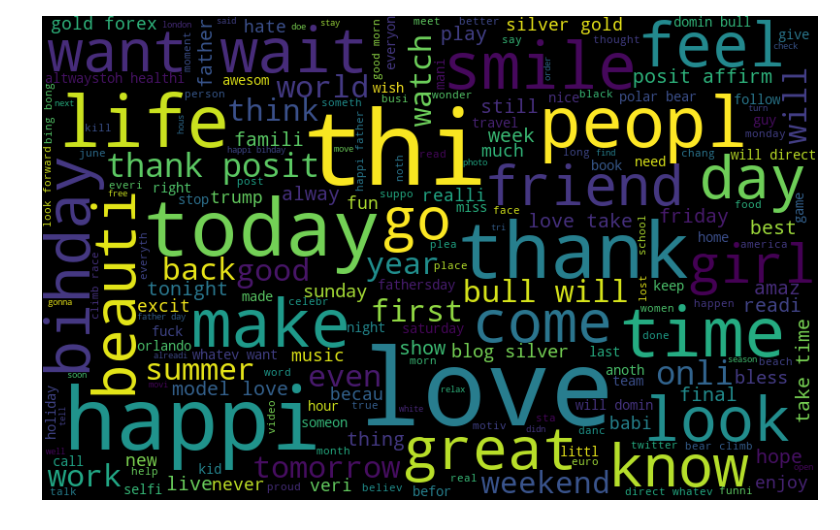

In [22]:
all_words = ' '.join([text for text in combi['tidy_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

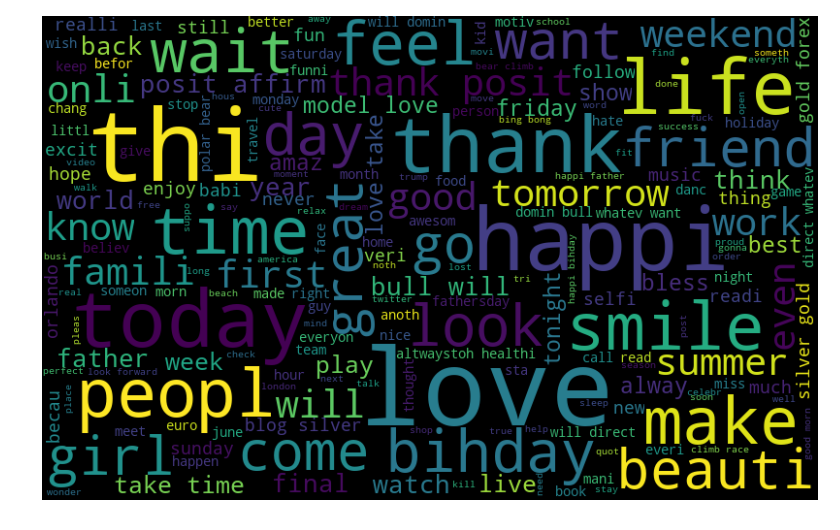

In [23]:
#Words in non racist/sexist tweets
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

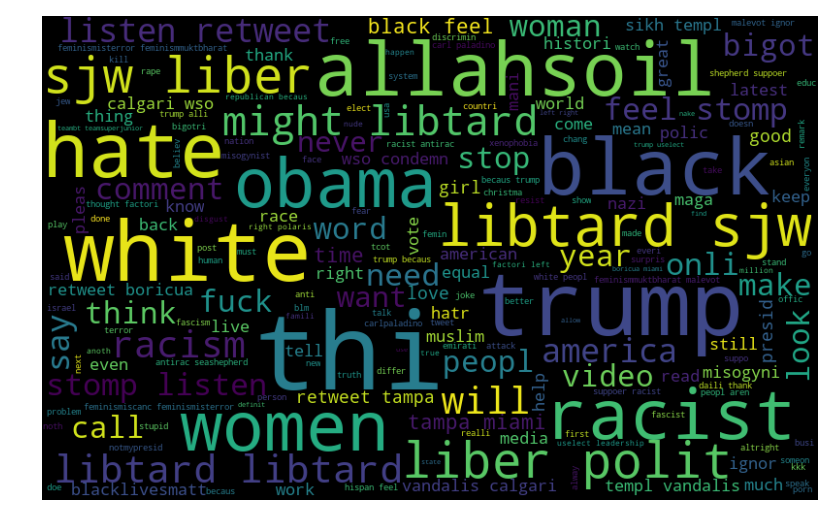

In [24]:
#Racists Sexist Tweets
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

D) Understanding the impact of Hashtags on tweets sentiment

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:


The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets

In [25]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = [] #Array defined
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [26]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])



In [27]:
# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

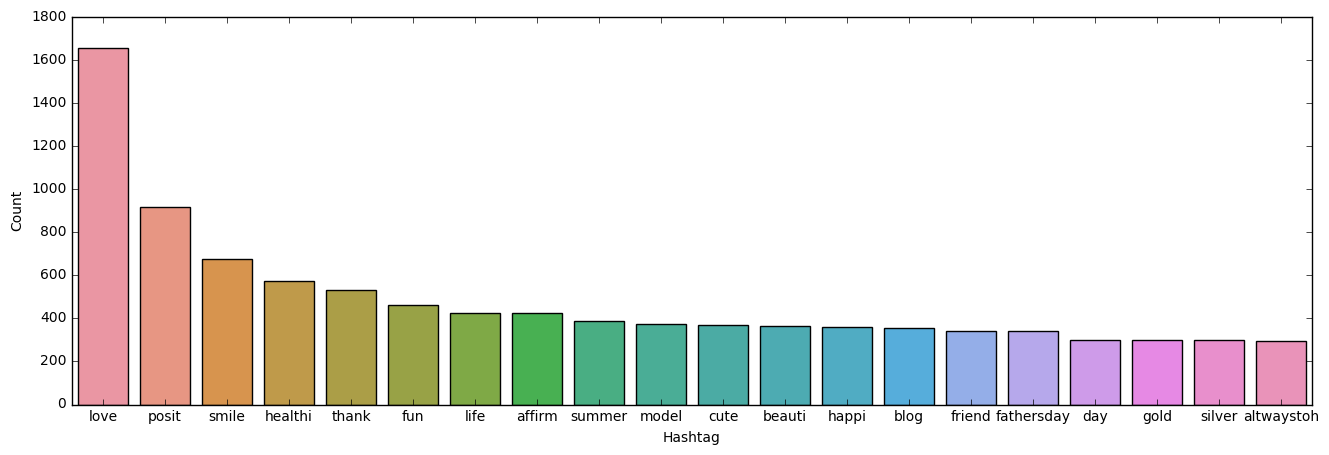

In [28]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count':   list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


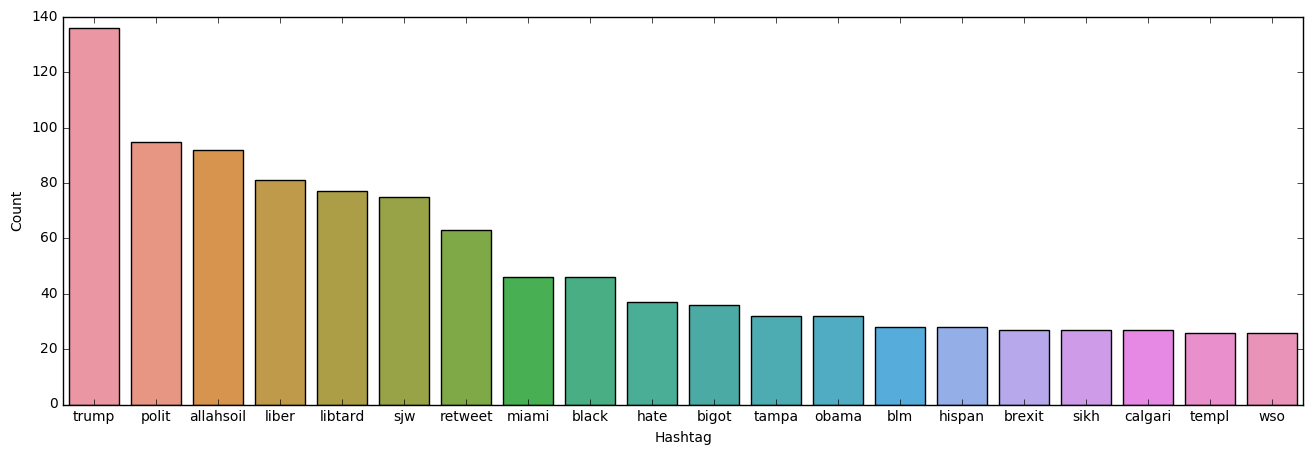

In [29]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")


As expected, most of the terms are negative with a few neutral terms as well. 
So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. 
Next, we will try to extract features from the tokenized tweets.

In [30]:
#Now We have to extract features

#Bag-of-Words Features
To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings. 
Read on to understand these techniques in detail.
Let’s start with the Bag-of-Words Features.

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).

Let us understand this using a simple example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [32]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape
#1000 unique words

(49159, 1000)

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.
#TF-IDF Features
TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

TF = (Number of times term t appears in a document)/(Number of terms in the document)

IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

TF-IDF = TF*IDF

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

C:\Users\singh\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1015: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(49159, 1000)

#Word@Vec
Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. 
They are able to achieve tasks like King -man +woman = Queen, which is mind-blowing

The advantages of using word embeddings over BOW or TF-IDF are:

Dimensionality reduction - significant reduction in the no. of features required to build a model.

It capture meanings of the words, semantic relationships and the different types of contexts they are used in.



1. Word2Vec Embeddings

Word2Vec is not a single algorithm but a combination of two techniques – CBOW (Continuous bag of words) and Skip-gram model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.




There are three laters: - an input layer, - a hidden layer, and - an output layer.

The input layer and the output, both are one- hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

We will go ahead with the Skip-gram model as it has the following advantages:

It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

Skip-gram with negative sub-sampling outperforms CBOW generally.

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using pre-trained word vectors instead of training our own model. Some of the freely available pre-trained vectors are:

Google News Word Vectors -https://code.google.com/archive/p/word2vec/

Freebase names

DBPedia vectors (wiki2vec)-https://github.com/idio/wiki2vec#prebuilt-models

However, for this course, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec model on our corpus.



However, for this course, we will train our own word vectors since size of the pre-trained word vectors is generally huge.

Let’s train a Word2Vec model on our corpus.

In [34]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

In [35]:
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6510028, 7536020)

Let’s play a bit with our Word2Vec model and see how does it perform. 
We will specify a word and the model will pull out the most similar words from the corpus.

In [36]:
model_w2v.wv.most_similar(positive="dinner")
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.5822896957397461),
 ('hillari', 0.5584967732429504),
 ('#delegaterevolt', 0.5482854843139648),
 ('phoni', 0.5388892889022827),
 ('melo', 0.5379345417022705),
 ('nomine', 0.52402663230896),
 ('unfit', 0.5239561796188354),
 ('potu', 0.5237712860107422),
 ('unstabl', 0.520860493183136),
 ('tomlin', 0.5191917419433594)]

From the above two examples, we can see that our word2vec model does a good job of finding the most similar words 
for a given word. But how is it able to do so? That’s because it has learned vectors for every unique word in our data and 
it uses cosine similarity to find out the most similar vectors (words).

In [37]:
#Let’s check the vector representation of any word from our corpus.

model_w2v['food']

array([-1.29978403e-01, -2.01397225e-01, -2.46048734e-01,  8.94541666e-02,
        6.97318688e-02, -1.92381799e-01,  1.75861374e-01, -4.99852896e-01,
        1.70759916e-01,  3.20045166e-02, -8.46948981e-01, -2.28907257e-01,
       -1.84732035e-01, -8.60148817e-02, -2.30493858e-01, -3.39528732e-02,
       -2.78330266e-01, -7.69571662e-01,  7.59605646e-01, -5.81303500e-02,
       -4.67492461e-01,  2.57362425e-01,  2.50103682e-01, -3.05399075e-02,
        5.68935871e-01,  3.06201071e-01, -2.44453073e-01, -6.35379195e-01,
       -4.64251310e-01, -2.97208697e-01,  2.70312071e-01,  4.58162755e-01,
        4.80177760e-01,  6.42085299e-02,  1.99083120e-01,  2.07391948e-01,
       -9.77849239e-04,  1.31710678e-01,  9.65353847e-02, -5.46578765e-01,
       -7.24987919e-03,  3.04309428e-01, -1.98029682e-01,  3.38800043e-01,
        2.45805129e-01,  1.97618399e-02, -6.06288433e-01, -9.16088164e-01,
        5.75451016e-01, -1.75381511e-01,  2.42361426e-01, -1.60161689e-01,
       -6.16691172e-01, -

Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [38]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [39]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

In [40]:
wordvec_df[1:]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1,-0.085045,0.250533,0.140005,0.045479,-0.116136,-0.085524,0.062141,-0.143537,0.194282,0.081159,...,-0.249590,0.185429,0.151537,-0.335641,-0.100060,-0.261522,0.072145,-0.111626,0.353720,0.081244
2,0.014773,0.097900,-0.009202,-0.209050,-0.508953,-0.053169,-0.170767,-0.263095,-0.038575,0.017651,...,0.170680,0.150195,0.165823,-0.465751,-0.044225,-0.006124,-0.141664,-0.146043,0.338535,-0.153351
3,-0.246070,0.012849,-0.002750,-0.021103,-0.276502,-0.179218,-0.130297,0.559534,0.140076,0.002036,...,-0.146584,0.217752,0.293116,-0.322345,-0.239598,-0.064109,-0.155525,-0.114147,0.100600,0.135460
4,-0.428076,0.001397,-0.050542,0.349943,0.293837,-0.003880,0.082426,-0.311747,0.402603,-0.235362,...,-0.261388,0.662621,0.215761,-0.252828,-0.286026,-0.122328,0.194534,0.124528,0.467299,0.148397
5,-0.267319,0.263045,0.230038,0.094104,0.134324,-0.108783,0.319345,-0.176912,0.167193,-0.211900,...,-0.068631,0.212007,0.322023,-0.388153,-0.440093,-0.087403,-0.057808,-0.034202,0.294323,0.274296
6,-0.063242,0.191574,-0.026782,0.580634,-0.334384,-0.006509,0.323632,-0.153201,0.310394,0.135175,...,0.148509,0.211549,-0.041399,-0.188859,-0.293653,0.023650,-0.074612,-0.084227,0.501476,0.012728
7,-0.064276,0.066459,0.145059,0.502664,-0.104188,-0.460330,0.040765,0.083823,0.187873,-0.040516,...,-0.084741,0.401725,0.109076,-0.152237,-0.282088,-0.169150,-0.111698,-0.075313,0.314754,-0.118883
8,-0.167959,0.155781,0.217922,0.273934,-0.145730,-0.017548,-0.377708,-0.014381,0.240127,-0.290775,...,0.107961,0.138402,-0.115349,-0.379467,-0.263143,-0.167313,-0.269706,-0.076151,0.177970,0.159996
9,0.209594,0.295106,0.107331,0.297056,-0.285230,0.157160,-0.004060,0.111355,0.101122,-0.145978,...,-0.094353,0.016288,0.509223,-0.467048,-0.443905,-0.358578,0.254172,0.097747,0.474362,0.109596
10,-0.398107,0.025282,-0.219555,0.217624,-0.530796,-0.009870,0.321934,-0.230059,0.026380,-0.215041,...,-0.216106,-0.086161,0.285828,-0.071583,-0.047263,-0.580062,0.191043,0.012534,0.857553,-0.050299


Doc2Vec model is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. 
This approach is an extension of the word2vec. 
The major difference between the two is that doc2vec provides an additional context which is unique for every document in the corpus. 
This additional context is nothing but another feature vector for the whole document. 
This document vector is trained along with the word vectors.

In [41]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

To implement doc2vec, 
we have to labelise or tag each tokenised tweet with unique IDs.
We can do so by using Gensim’s LabeledSentence() function.

In [42]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [43]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

In [44]:
labeled_tweets[:6]

[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'caus', 'they', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', '#motiv'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fare', 'talk', 'befor', 'they', 'leav', 'chao', 'disput', 'when', 'they', 'there', '#allshowandnogo'], tags=['tweet_5'])]

In [45]:
# Now let’s train a doc2vec model.

model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model dm_mean=1, # dm = 1 for using mean of the context word vectors size=200, # no. of desired features                                  
window=5, # width of the context window                                  
negative=7, # if > 0 then negative sampling will be used  min_count=5, # Ignores all words with total frequency lower than 2.                                  
workers=3, # no. of cores                                  
alpha=0.1, # learning rate                                  
seed = 23) 
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])
model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=15)

100%|███████████████████████████████████████████████████████████████████████| 49159/49159 [00:00<00:00, 3520966.37it/s]


In [46]:
#Preparing doc2vec Feature Set

docvec_arrays = np.zeros((len(tokenized_tweet), 100)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,100))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape


(49159, 100)

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

Logistic Regression
Support Vector Machine
RandomForest
XGBoost
Evaluation Metric

F1 score is being used as the evaluation metric. It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

The important components of F1 score are:

True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
False Positives (FP) – When actual class is no and predicted class is yes.
False Negatives (FN) – When actual class is yes but predicted class in no.
Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2(Recall Precision) / (Recall + Precision)

Bag-of-Words Features

We will first try to fit the logistic regression model on the Bag-of_Words (BoW) features.

In [47]:
from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

In [48]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 
# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],random_state=42, test_size=0.3)
lreg = LogisticRegression() 
# training the model 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5307820299500832

In [49]:
test_pred = lreg.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']] 
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [50]:
#TF-IDF Features

#We’ll follow the same steps as above, but now for the TF-IDF feature set.

train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 
xtrain_tfidf = train_tfidf[ytrain.index] 
xvalid_tfidf = train_tfidf[yvalid.index]
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set



0.5446507515473032

In [51]:
#Word2Vec Features

train_w2v = wordvec_df.iloc[:31962,:] 
test_w2v = wordvec_df.iloc[31962:,:] 
xtrain_w2v = train_w2v.iloc[ytrain.index,:] 
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain) 
prediction = lreg.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)


0.6095940959409594

In [52]:
#Doc2Vec Features

train_d2v = docvec_df.iloc[:31962,:] 
test_d2v = docvec_df.iloc[31962:,:] 
xtrain_d2v = train_d2v.iloc[ytrain.index,:] 
xvalid_d2v = train_d2v.iloc[yvalid.index,:]
lreg.fit(xtrain_d2v, ytrain) 
prediction = lreg.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)


0.37735849056603776

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. 
However, it is mostly used in classification problems. 
In this algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) 
with the value of each feature being the value of a particular coordinate. Then, we perform classification by 
finding the hyper-plane that differentiate the two classes as shown in the plot below

In [53]:
from sklearn import svm


In [54]:
#Bag-of-Words Features

svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5092936802973977

In [55]:
#Again let’s make predictions for the test dataset and create another submission file.

test_pred = svc.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']] 
submission.to_csv('sub_svm_bow.csv', index=False)

In [56]:
#TF-IDF Features

svc = svm.SVC(kernel='linear', 
C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5104831358249772

In [57]:
#Word2Vec Features

svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.603921568627451

Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.

Some key benefits of XGBoost are:

Regularization - helps in reducing overfitting

Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

Handling Missing Values - It has an in-built routine to handle missing values.

Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process

In [58]:
from xgboost import XGBClassifier

In [59]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain) 
prediction = xgb_model.predict(xvalid_bow) 
f1_score(yvalid, prediction)

test_pred = xgb_model.predict(test_bow) 
test['label'] = test_pred 
submission = test[['id','label']] 
submission.to_csv('sub_xgb_bow.csv', index=False)

In [60]:
#Word2Vec Features

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

0.6388384754990926

In [61]:
#Doc2Vec Features

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain) 
prediction = xgb.predict(xvalid_d2v) 
f1_score(yvalid, prediction)

0.31870669745958424

XGBoost with Word2Vec model has given us the best performance so far. 
Let’s try to tune it further to extract as much from it as we can. 
XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. 
This is what we are going to do in the following steps. 
You can refer this guide to learn more about parameter tuning in XGBoost.

In [62]:
import xgboost as xgb

In [63]:
#Here we will use DMatrices. A DMatrix can contain both the features and the target.

dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
dtest = xgb.DMatrix(test_w2v)

In [64]:
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }


In [65]:
#We will prepare a custom evaluation metric to calculate F1 score.

def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]


General Approach for Parameter Tuning

We will follow the steps below to tune the parameters.

Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.

Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

Tune the learning rate.

Finally tune gamma to avoid overfitting.

In [66]:
#Tuning max_depth and min_child_weight

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
     for min_child_weight in range(5,8)
 ]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
     # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

     # Cross-validation
    cv_results = xgb.cv(        params,
        dtrain,        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )     

CV with max_depth=6, min_child_weight=5
CV with max_depth=6, min_child_weight=6
CV with max_depth=6, min_child_weight=7
CV with max_depth=7, min_child_weight=5
CV with max_depth=7, min_child_weight=6
CV with max_depth=7, min_child_weight=7
CV with max_depth=8, min_child_weight=5
CV with max_depth=8, min_child_weight=6
CV with max_depth=8, min_child_weight=7
CV with max_depth=9, min_child_weight=5
CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7


In [70]:
# Finding best F1 Score
    
mean_f1 = cv_results['test-f1_score-mean'].max()
    
boost_rounds = cv_results['test-f1_score-mean'].argmax()    
print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    
if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

	F1 Score 0.6700672 for 38 rounds
Best params: 9, 7, F1 Score: 0.6700672


In [71]:
#Updating max_depth and min_child_weight parameters.

params['max_depth'] = 8 
params['min_child_weight'] = 6


In [72]:
#Tuning subsample and colsample

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)] ]
max_f1 = 0. 
best_params = None 
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
     # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )
     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5
	F1 Score 0.6631124 for 61 rounds
CV with subsample=0.5, colsample=0.6
	F1 Score 0.6631124 for 61 rounds
CV with subsample=0.5, colsample=0.7
	F1 Score 0.6631124 for 61 rounds
CV with subsample=0.5, colsample=0.8
	F1 Score 0.6631124 for 61 rounds
CV with subsample=0.5, colsample=0.9
	F1 Score 0.6631124 for 61 rounds
CV with subsample=0.6, colsample=0.5
	F1 Score 0.6664052 for 35 rounds
CV with subsample=0.6, colsample=0.6
	F1 Score 0.6664052 for 35 rounds
CV with subsample=0.6, colsample=0.7
	F1 Score 0.6664052 for 35 rounds
CV with subsample=0.6, colsample=0.8
	F1 Score 0.6664052 for 35 rounds
CV with subsample=0.6, colsample=0.9
	F1 Score 0.6664052 for 35 rounds
CV with subsample=0.7, colsample=0.5
	F1 Score 0.676248 for 50 rounds
CV with subsample=0.7, colsample=0.6
	F1 Score 0.676248 for 50 rounds
CV with subsample=0.7, colsample=0.7
	F1 Score 0.676248 for 50 rounds
CV with subsample=0.7, colsample=0.8
	F1 Score 0.676248 for 50 rounds
CV with su

In [73]:
#Updating subsample and colsample_bytree

params['subsample'] = .9 
params['colsample_bytree'] = .5




In [74]:
#Now let’s tune the learning rate.

max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
     # Update ETA
    params['eta'] = eta

     # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3
	F1 Score 0.6793663999999999 for 63 rounds
CV with eta=0.2
	F1 Score 0.6854964 for 51 rounds
CV with eta=0.1
	F1 Score 0.6937512000000001 for 141 rounds
CV with eta=0.05
	F1 Score 0.6981192 for 199 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.05, F1 Score: 0.6981192


In [75]:
{'colsample': 0.9,
 'colsample_bytree': 0.5, 'eta': 0.1,
 'max_depth': 8, 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.9}

{'colsample': 0.9,
 'colsample_bytree': 0.5,
 'eta': 0.1,
 'max_depth': 8,
 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.9}

In [76]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

[0]	Validation-error:0.064449	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.05767	Validation-f1_score:0.133165
[2]	Validation-error:0.056106	Validation-f1_score:0.133165
[3]	Validation-error:0.057462	Validation-f1_score:0.133165
[4]	Validation-error:0.05548	Validation-f1_score:0.133165
[5]	Validation-error:0.056002	Validation-f1_score:0.133165
[6]	Validation-error:0.055272	Validation-f1_score:0.133165
[7]	Validation-error:0.05548	Validation-f1_score:0.133165
[8]	Validation-error:0.055063	Validation-f1_score:0.133165
[9]	Validation-error:0.05475	Validation-f1_score:0.133165
[10]	Validation-error:0.054333	Validation-f1_score:0.133165
Stopping. Best iteration:
[0]	Validation-error:0.064449	Validation-f1_score:0.133165

